In [6]:
import matplotlib.pyplot as plt
import os
height = 8
width = height*1.6
plt.rcParams["figure.figsize"] = (width,height)
import numpy as np

# import torch
# from torch.distributions import Categorical

# soft = np.full((10),0.1)
# max_val = Categorical(probs = torch.from_numpy(soft)).entropy().numpy()
# print(max_val)

plt.style.use('seaborn-colorblind')

def load(directory,thresholds):
    exit_directory = directory+'/metrics/threshold-test/'
    exits = list()
    accuracies = list()
    
    for idx, entropy_threshold in enumerate(thresholds):
        exit = np.load(exit_directory+'exits-threshold-'+str(entropy_threshold)+'.npy')
        exits.append(exit)
        accuracy = np.load(exit_directory+'accuracies-threshold-'+str(entropy_threshold)+'.npy')
        accuracies.append(accuracy)
        
    exits = np.array(exits)
    accuracies = np.array(accuracies)
        
    mac_readings = np.load(directory+'/metrics/layerwise_macs.npy')
    
    return exits,accuracies,mac_readings

def get_label(branch_weights, model = 'B-Rnet ('):
    string = model
    for weight in branch_weights:
        weight = np.round(weight,decimals=3)
        string = string + str(weight) + " : "
    string = string[:-3]+')'
    return(string)

def get_exit_p(exit_readings):
    n_samples = exit_readings.shape[2]
    all_exits = list()
    for model in exit_readings:
        multi_run_exits = list()
        for run in model:
            exits = list()
            for i in range(4):
                exits.append(np.sum(run==i))
            multi_run_exits.append(exits)
        multi_run_exits=np.array(multi_run_exits)
        all_exits.append(multi_run_exits)

    all_exits = np.array(all_exits)
    mean_exits = np.mean(all_exits,axis=1)
    std_exits = np.std(all_exits,axis=1)

    exit_p = mean_exits/n_samples
    exit_p_std = std_exits/n_samples
    
    return(exit_p, exit_p_std)

def get_MACs_acc(directory, thresholds, important, layers):
    model = directory.split('/')[2]
    exits, accs, macs = load(directory,thresholds)
    layerwise_macs = np.take(macs,important)
    branch_weights = np.load(directory+"/metrics/branch-weights-"+model+".npy")
    label = get_label(branch_weights,model = (model+" ("))
        
    powers = np.zeros(4)
    powers[0]  = np.sum(np.take(layerwise_macs,layers[0]))
    powers[1]  = np.sum(np.take(layerwise_macs,layers[1]))
    powers[2]  = np.sum(np.take(layerwise_macs,layers[2]))
    powers[3]  = np.sum(layerwise_macs)
    
    print(directory.split('/')[2],directory.split('/')[3],directory.split('/')[4])

    # for idx in range(exits.shape[0]):
    #     print("Threshold:", thresholds[idx]," exit counts:")
        
    #     print("Exit 1 %:", (np.sum(exits[idx,:,:]==0)/30000)) 
    #     print("Exit 2 %:", (np.sum(exits[idx,:,:]==1)/30000))
    #     print("Exit 3 %:", (np.sum(exits[idx,:,:]==2)/30000)) 
    #     print("Exit 4 %:", (np.sum(exits[idx,:,:]==3)/30000)) 
    
    exit_p, exit_p_std = get_exit_p(exits)
    
    
    avg_powers = np.zeros(exit_p.shape[0])
    avg_powers_std = np.zeros(exit_p.shape[0])
    
    for idx,  threshold in enumerate(exit_p):
        avg_powers[idx] = np.sum(np.multiply(threshold,powers))
        avg_powers_std[idx] = np.sum(np.multiply(exit_p_std[idx],powers))
    
    avg_accs = np.mean(accs,axis=1)
    
    return avg_powers, avg_accs, label, exit_p

In [7]:
directory = "../trained-models/BranchedMobileNet/CIFAR10/CA-ls-wb101-b202-b303/"

confidence_thresholds = [2.25,2.0,1.75,1.5,1.25,1.0,0.75,0.5,0.25,0.0]

mobile_net_layers = [2,6,10,16,20,36,48,61,79,98,117,135,154,172,191,210,214,218]
mobile_net_branches = [[0,3,4,5],[0,1,3,4,5,6,7,8],[0,1,2,3,4,6,7,8,9,10,11,12]]

powers, accs, label, exit_p = get_MACs_acc(directory, confidence_thresholds, mobile_net_layers, mobile_net_branches)

print(exit_p)
print(powers.shape)
print(accs.shape)

BranchedMobileNet CIFAR10 CA-ls-wb101-b202-b303
[[9.99966667e-01 3.33333333e-05 0.00000000e+00 0.00000000e+00]
 [9.05233333e-01 6.23666667e-02 3.12666667e-02 1.13333333e-03]
 [6.57700000e-01 1.68466667e-01 1.60766667e-01 1.30666667e-02]
 [4.32333333e-01 2.23766667e-01 3.00700000e-01 4.32000000e-02]
 [2.68066667e-01 2.28233333e-01 4.12200000e-01 9.15000000e-02]
 [1.43633333e-01 2.00233333e-01 4.96000000e-01 1.60133333e-01]
 [5.77000000e-02 1.39700000e-01 5.47266667e-01 2.55333333e-01]
 [1.24666667e-02 6.72666667e-02 4.13966667e-01 5.06300000e-01]
 [5.33333333e-04 1.37000000e-02 4.59666667e-02 9.39800000e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]
(10,)
(10,)


BranchedMobileNet CIFAR10 CA-ls-wb101-b202-b303
BranchedMobileNet CIFAR10 CA-ls-wb102-b202-b302
BranchedMobileNet CIFAR10 CA-ls-wb102-b201-b303
BranchedMobileNet CIFAR10 CA-ls-wb102-b203-b301
BranchedResNet18 CIFAR10 CA-wb101-b202-b303
BranchedResNet18 CIFAR10 CA-wb102-b202-b302
BranchedResNet18 CIFAR10 CA-wb102-b201-b303
BranchedResNet18 CIFAR10 CA-wb102-b203-b301


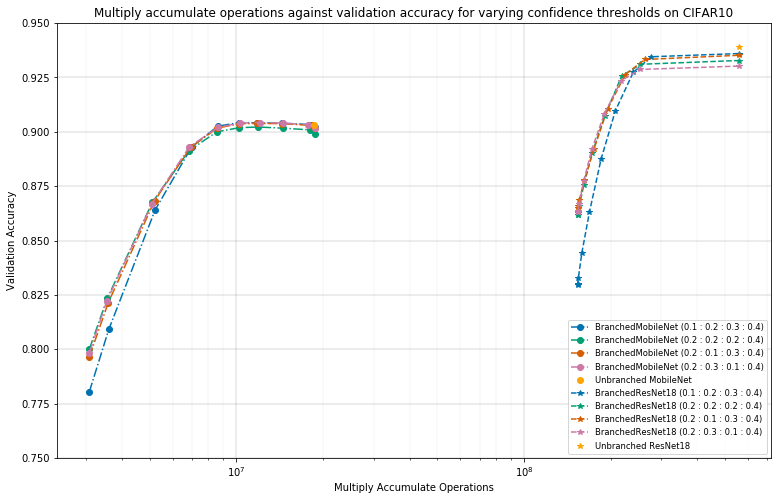

In [8]:
# dataset = 'eurosat-rgb'
dataset = 'CIFAR10'
# dataset = 'sat-6'

simplenet_sat6 = 557875206.0
spectrumnet_dsc = 75.59e6
spectrumnet_standard = 203.47e6
resnet_power_sat6 = 458113542.0
resnet_power_CIFAR = 556651530.0
mobilenet_power_CIFAR = 18582632.0
mobilenet_power_sat6 = 15892068.0

directory = "../trained-models/BranchedMobileNet/"+dataset+"/CA-ls-"
names = ["wb101-b202-b303","wb102-b202-b302","wb102-b201-b303","wb102-b203-b301"] 

mobile_net_layers = [2,6,10,16,20,36,48,61,79,98,117,135,154,172,191,210,214,218]
mobile_net_branches = [[0,3,4,5],[0,1,3,4,5,6,7,8],[0,1,2,3,4,6,7,8,9,10,11,12]]

colours = ['orangered','seagreen', 'darkmagenta', 'orange']

confidence_thresholds = [2.25,2.0,1.75,1.5,1.25,1.0,0.75,0.5,0.25,0.0]

mobile_exit_p = np.zeros((len(names),len(confidence_thresholds),4))
mobile_labels = list()

for idx, name in enumerate(names):
    colour = colours[idx]
    plot_directory = directory+name
    powers,accs,label,mobile_exit_p[idx,:,:] = get_MACs_acc(plot_directory, confidence_thresholds, mobile_net_layers, mobile_net_branches)
    mobile_labels.append(label)
    plt.plot(powers,accs,'-.o',label=label)#,color = colour)
#     plt.errorbar(powers, accs, yerr=std, fmt='o', color='black',ecolor='lightgray', elinewidth=3, capsize=0);


mobilenet_power = np.sum(powers[3:])
plot_directory = "../trained-models/BranchedMobileNet/"+dataset+"/CA-unbranched/"
accs = np.load(plot_directory+"metrics/branch-val-accuracies-BranchedMobileNet.npy")
u_mnet_acc = np.max(np.mean(accs[:,-1,:],axis=0))
plt.plot(mobilenet_power_CIFAR,u_mnet_acc,'o',label='Unbranched MobileNet',color = 'orange')



plt.gca().set_prop_cycle(None)    
directory = "../trained-models/BranchedResNet18/"+dataset+"/CA-"
names = ["wb101-b202-b303","wb102-b202-b302","wb102-b201-b303","wb102-b203-b301"] 
# names = ["wb101-b202-b303","wb102-b202-b302","wb102-b203-b301"] 

res_net_layers = [1,2,3,16,31,46,61,62,63,64]
res_net_branches = [[0,1,2,6],[0,1,2,3,6,7],[0,1,2,3,4,6,7,8]]

resnet_exit_p = np.zeros((len(names),len(confidence_thresholds),4))
resnet_labels = list()

for idx, name in enumerate(names):
    colour = colours[idx]
    plot_directory = directory+name
    powers,accs,label,resnet_exit_p[idx,:,:] = get_MACs_acc(plot_directory, confidence_thresholds, res_net_layers, res_net_branches)
    plt.plot(powers,accs,'--*',label=label)#,color = colour)
    resnet_labels.append(label)
#     plt.errorbar(powers, accs, yerr=std, fmt='o', color='black',ecolor='lightgray', elinewidth=3, capsize=0);
    
resnet_power = np.sum(powers[3:])
plot_directory = "../trained-models/BranchedResNet18/"+dataset+"/CA-unbranched/"
accs = np.load(plot_directory+"metrics/branch-val-accuracies-BranchedResNet18.npy")
u_rnet_acc = np.max(np.mean(accs[:,-1,:],axis=0))
plt.plot(resnet_power_CIFAR,u_rnet_acc,'*',label='Unbranched ResNet18',color = 'orange')

# plt.plot(spectrumnet_dsc,0.876,'v',label='SpectrumNet w/ DSC',color = 'orangered')
# plt.plot(spectrumnet_standard,0.921,'^',label='SpectrumNet',color = 'orangered')

# plt.plot(simplenet_sat6,0.9947,'v',label='Simplenet',color = 'orangered')

#Defining properties of axes
plt.xscale('log')
plt.ylim(0.75,0.95)
plt.grid(color='grey', linestyle='-', linewidth=0.3)
plt.grid(which='minor',color='lightgrey', linestyle='--', linewidth=0.3)
plt.title('Multiply accumulate operations against validation accuracy for varying confidence thresholds on ' + dataset)
plt.ylabel('Validation Accuracy')
plt.xlabel('Multiply Accumulate Operations')
plt.legend(fontsize='small')

#saveplot
plt.savefig('../trained-models/figures/'+dataset+'-thresholded-Macs-acc.pdf')

#show plot
plt.show()

[[9.99966667e-01 9.05233333e-01 6.57700000e-01 4.32333333e-01
  2.68066667e-01 1.43633333e-01 5.77000000e-02 1.24666667e-02
  5.33333333e-04 0.00000000e+00]
 [3.33333333e-05 6.23666667e-02 1.68466667e-01 2.23766667e-01
  2.28233333e-01 2.00233333e-01 1.39700000e-01 6.72666667e-02
  1.37000000e-02 0.00000000e+00]
 [0.00000000e+00 3.12666667e-02 1.60766667e-01 3.00700000e-01
  4.12200000e-01 4.96000000e-01 5.47266667e-01 4.13966667e-01
  4.59666667e-02 0.00000000e+00]
 [0.00000000e+00 1.13333333e-03 1.30666667e-02 4.32000000e-02
  9.15000000e-02 1.60133333e-01 2.55333333e-01 5.06300000e-01
  9.39800000e-01 1.00000000e+00]]


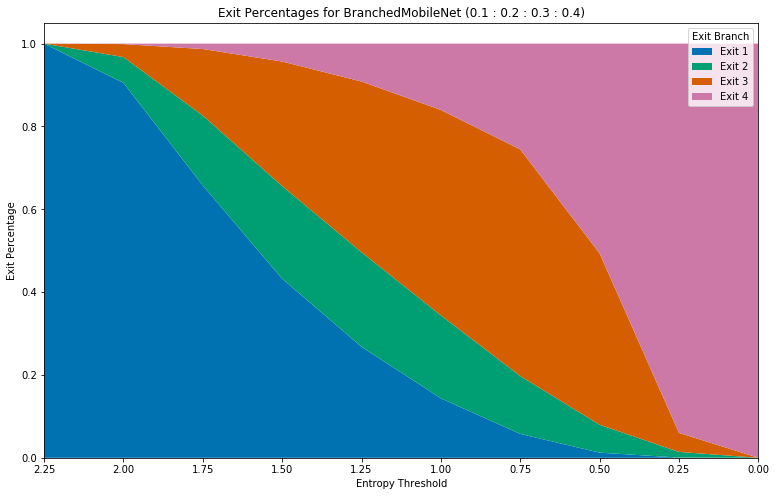

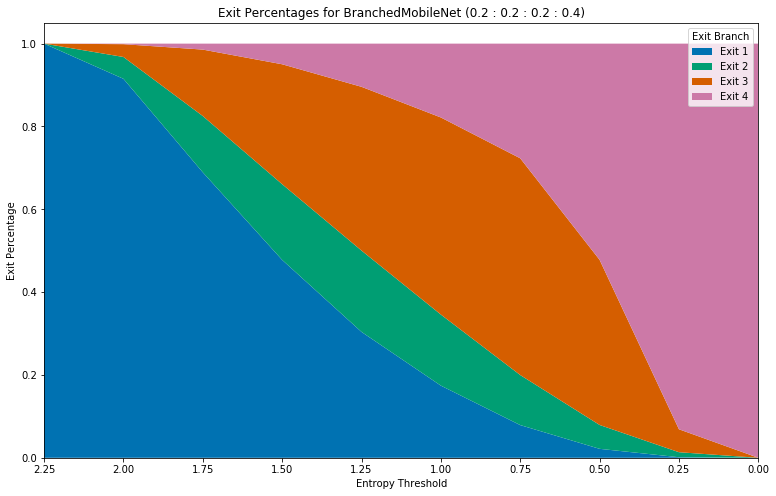

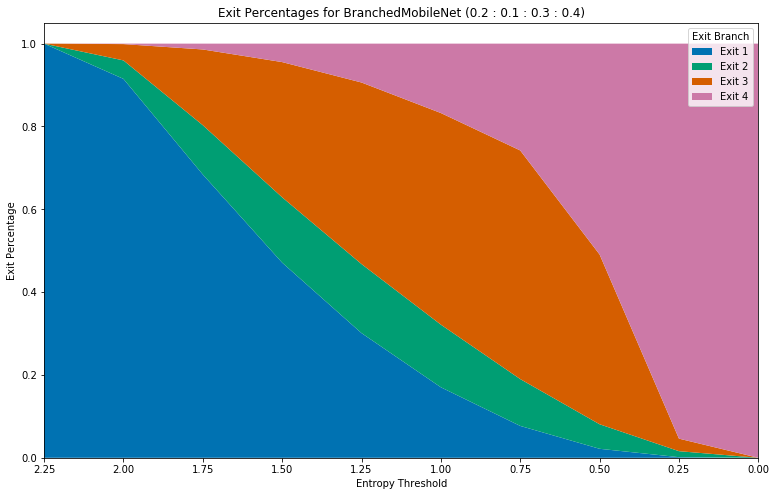

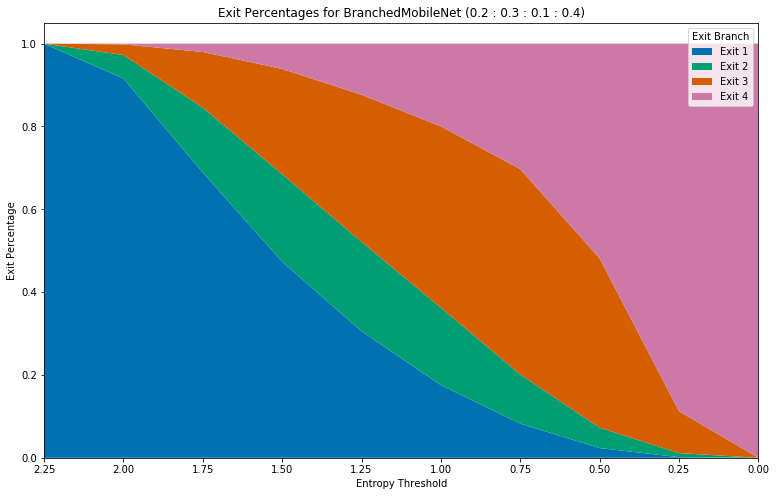

[[9.99966667e-01 9.05233333e-01 6.57700000e-01 4.32333333e-01
  2.68066667e-01 1.43633333e-01 5.77000000e-02 1.24666667e-02
  5.33333333e-04 0.00000000e+00]
 [3.33333333e-05 6.23666667e-02 1.68466667e-01 2.23766667e-01
  2.28233333e-01 2.00233333e-01 1.39700000e-01 6.72666667e-02
  1.37000000e-02 0.00000000e+00]
 [0.00000000e+00 3.12666667e-02 1.60766667e-01 3.00700000e-01
  4.12200000e-01 4.96000000e-01 5.47266667e-01 4.13966667e-01
  4.59666667e-02 0.00000000e+00]
 [0.00000000e+00 1.13333333e-03 1.30666667e-02 4.32000000e-02
  9.15000000e-02 1.60133333e-01 2.55333333e-01 5.06300000e-01
  9.39800000e-01 1.00000000e+00]]


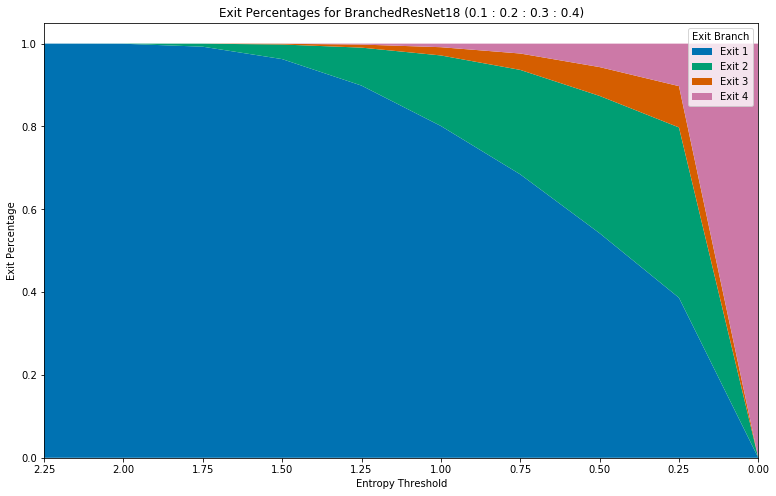

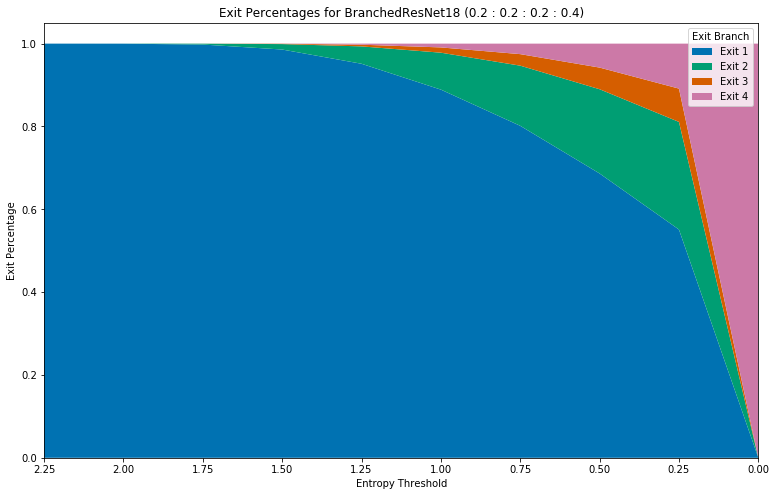

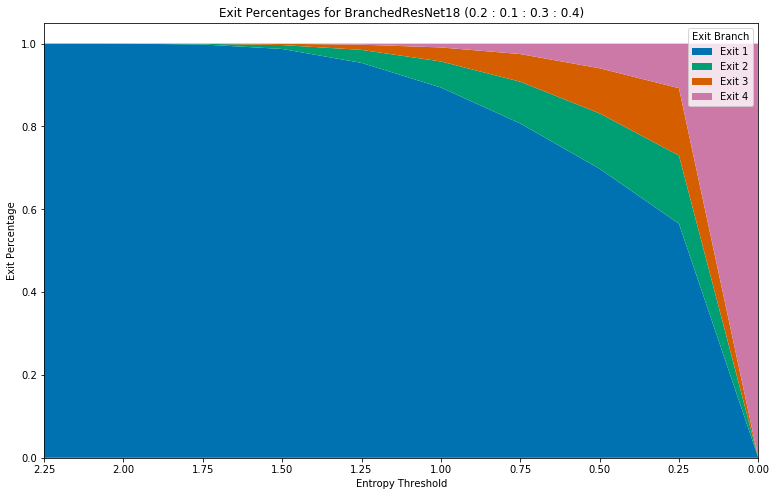

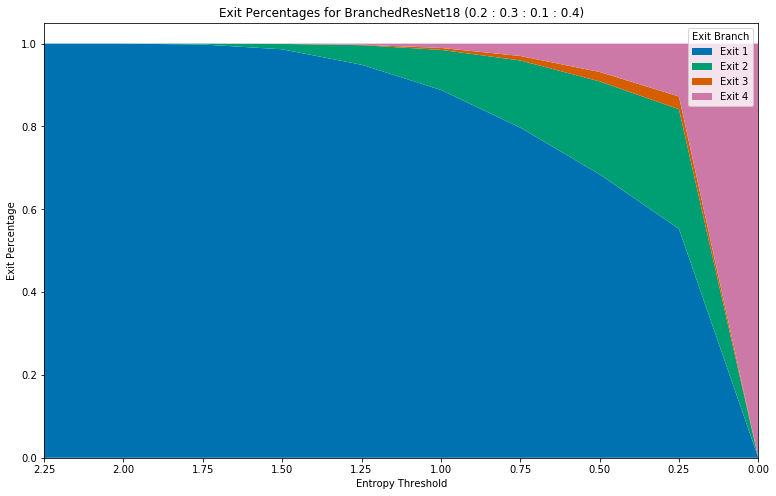

In [9]:
print(mobile_exit_p[0,:,:].T)
for idx, label in enumerate(mobile_labels):
    plt.stackplot(confidence_thresholds,mobile_exit_p[idx,:,:].T,labels=['Exit 1','Exit 2','Exit 3','Exit 4'])
    plt.title('Exit Percentages for ' + label)
    plt.xlim(2.25,0)
    plt.ylabel('Exit Percentage')
    plt.xlabel('Entropy Threshold')
    plt.legend(title='Exit Branch')
    plt.show()

print(mobile_exit_p[0,:,:].T)
for idx, label in enumerate(resnet_labels):
    plt.stackplot(confidence_thresholds,resnet_exit_p[idx,:,:].T,labels=['Exit 1','Exit 2','Exit 3','Exit 4'])
    plt.title('Exit Percentages for ' + label)
    plt.xlim(2.25,0)
    plt.ylabel('Exit Percentage')
    plt.xlabel('Entropy Threshold')
    plt.legend(title='Exit Branch')
    plt.show()